In [11]:
import classes
import functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join

In [12]:
#puntje 2: definiëren van de functies
k, omega, p_0, p_0_x, phi, v, x, t, A_min, r = sp.symbols('k omega p_0 p_0_x phi v x t C r')

#max amplitude in functie van x 
drukamplitude_vergelijking = classes.vergelijking(p_0 * sp.sin(k*x + phi))
drukamplitude_parameters = ['k', 'p_0', 'phi', 'C']

def drukamplitude_model(X, parameters):
    K, P_0, PHI, C = parameters
    return P_0 * abs(np.sin(K*X + PHI) + C) #bij de x-fit steeds positief (anders breekt het omdat de vorige fit brakt)

#amplitude in functie van tijd voor vaste x 
druktijd_vergelijking = classes.vergelijking(p_0*sp.sin(omega*t+phi)) #merk op dat dit niet per sé dezelfde phi is als voor x, maar is irrelevant voor de fitcode
druktijd_parameters = ['omega', 'p_0_x', 'phi', 'C']

def druktijd_model(T, parameters):
    omega, P_0, phi, C = parameters
    return P_0*np.sin(omega*T+phi) + C

#snelheid als omega en k gekend zijn
snelheid_vergelijking = classes.vergelijking(omega/k *10**5) #de 10**5 is om de vage eenheden die nodig zijn om de fits te doen werken te fixen
staande_golf_verhouding = classes.vergelijking((p_0*(1+A_min) - A_min)/(p_0*(1+A_min)+A_min))

In [13]:
###sjoemeliere sjoemelare om de txt files met de data om te zetten in effectieve nuttige dataverwerkingen
#blah blah...

###TEST_DATA:

X = np.array([0,100,200,300]) #een vector met de x-coordinaten van de metingen
T = np.array(
    [ np.linspace(1,15),
      np.linspace(0,10), #een matrix met de tijden voor elke meting op elke x-coordinaat
      np.linspace(1,11),
      np.linspace(7, 27)
])

P = np.array(
    [ 0*np.linspace(1,15) + np.random.normal(0,1),
     0.5*np.sin(np.linspace(0,10)+3)+np.random.normal(0,1), #een matrix met coordinaten P[x_coordinaat][tijd] #random normale fouten ingevoegd voor de test
          np.sin(np.linspace(0,10)+np.random.normal(0,1)), 
      0.5*np.sin(np.linspace(0,10)-1)+np.random.normal(0,1)
])
P_fout = np.full(np.shape(P), 1) #een matrix van dezelfde vorm als P met de fouten in



xval = 0

In [14]:
###vind de drukamplitude voor een vaste x-coordinaat
def fit_vaste_x(X, T, P, P_fout, invals = None, print_tijdfit = True, detailed_logs = False, return_fit_stats = False):
    """
    @IN:
    matrices X, T P en P_fout als gedefinieerd in vorige opgave
    @OUT:
    een lijst met maximale amplitude, in de volgorde van de x-coordinaat waarin ze voorkomen, en de pulsatie in datapuntvorm
    """
    
    P_0_x = []
    omega_x = []
    fits_stats = []
    for xval in range(len(X)):
        def invals_amplitude(x,y):
            if invals is None:
                return [1,0,0,0]
            else:
                return invals[xval]
        druk = P[xval]
        drukfout = P_fout[xval]
        tijd = T[xval]
        print('nummer:',xval)
        print('afstand:',X[xval])
        if return_fit_stats:
            tijdfit = functies.fit(druktijd_parameters, druktijd_model, invals_amplitude, tijd, druk, drukfout, detailed_logs = detailed_logs, fuck_CPU=True, return_fit_stats=return_fit_stats)
            fit_stats = tijdfit[-1]
            fits_stats.append(fit_stats)
        else:
            tijdfit = functies.fit(druktijd_parameters, druktijd_model, invals_amplitude, tijd, druk, drukfout, detailed_logs = detailed_logs,fuck_CPU = True, return_fit_stats=return_fit_stats)
        print('\n\n')
        if not return_fit_stats:
            print(tijdfit, 'tijdfit')
        else:
            print(tijdfit[:-1], 'tijdfit')
        omega_x.append(functies.vector_to_datapunt(tijdfit[0].copy(), omega))
        P_0_x.append(tijdfit[1].copy())

        if print_tijdfit:
            print('x-coordinaat:',X[xval])
            #plot het boeltje om te testen
            fig, ax = plt.subplots(1,1, figsize = (30,10))
            ax.errorbar(tijd, druk, yerr = drukfout, label = 'gemeten', fmt = "o" ,zorder = 1)
            T_fit = np.linspace(0, max(tijd),30000)
            druk_fit = tijdfit[1][0]*np.sin(tijdfit[0][0]*T_fit+tijdfit[2][0]) + tijdfit[3][0]
            ax.plot(T_fit, druk_fit, label = 'model', zorder = 2)
            testing = np.full(np.shape(T_fit), np.max(druk)) #Mijn vader beweerde iets raar te zien in de data, dus ff checken
            testing_min = np.full(np.shape(T_fit), np.min(druk)) #tis fine denk ik
            ax.plot(T_fit, testing)
            ax.plot(T_fit, testing_min)

            ax.set_ylabel('$V_0$ [mV]')
            ax.set_xlabel('T (s)')
            ax.legend("druk in functie van tijd")
            ax.legend()
            plt.tight_layout()
            plt.show()



    OMEGA = functies.mu_sigma(omega_x, omega)

    if return_fit_stats:
        return P_0_x, OMEGA, np.transpose(np.array(fits_stats))
    return P_0_x, OMEGA

#fix de drukamplitude naar de x-coordinaat
def fit_naar_x(X, P_0_x, P_0_x_ERR, invals = None, range_x = None, detailed_logs = False, fuck_mijn_pc = False, fuck_CPU = False):
    def invals_naarx(x,y):
        if invals is None:
            return [0,0,0,0]
        else:
            return invals
    fitwaardes = functies.fit(drukamplitude_parameters, drukamplitude_model, invals_naarx, X, P_0_x, P_0_x_ERR, initial_range=range_x, detailed_logs= detailed_logs, fuck_mijn_pc=fuck_mijn_pc, fuck_CPU = fuck_CPU)
    K = functies.vector_to_datapunt(fitwaardes[0], k)
    P_0 = functies.vector_to_datapunt(fitwaardes[1], p_0)
    PHI = functies.vector_to_datapunt(fitwaardes[2], phi)
    c = fitwaardes[3]
    return K, P_0, PHI, c

#voor de experimenten met vaste frequentie:
def fix_data(X, T, P, P_fout, invals_vaste_x = None, gok_snelheid = 380,range_x = None,fuck_mijn_pc=False, detailed_logs = False, invals_x = None,
             print_tijdfit = True, fit_x_vals = True, fuck_CPU = False, saveto = None, return_fit_stats = False, titel = None, fuck_mijn_pc_x = False, x_plot_max = None, gun_punten = False):
    #fit voor elke mogelijke vaste x zodat je amplitude(x) vindt
    if return_fit_stats and not print_tijdfit:
        P_0_x_lijst, OMEGA, fit_stats = fit_vaste_x(X, T, P, P_fout, invals_vaste_x, print_tijdfit = print_tijdfit, detailed_logs = detailed_logs and print_tijdfit, return_fit_stats=return_fit_stats and not print_tijdfit)
    else:
        P_0_x_lijst, OMEGA = fit_vaste_x(X, T, P, P_fout, invals_vaste_x, print_tijdfit = print_tijdfit, detailed_logs = detailed_logs and print_tijdfit, return_fit_stats=return_fit_stats and not print_tijdfit)
    P_0_x = [P_0_x_elem[0] for P_0_x_elem in P_0_x_lijst]
    P_0_x_ERR = [P_0_x_elem[1] for P_0_x_elem in P_0_x_lijst]
    print(P_0_x_ERR, 'P_0(x): de error')
    if return_fit_stats and not print_tijdfit:
        print(fit_stats, 'De fit stats voor de tijd fits')
    P_0_x = np.array(P_0_x)
    #fix dat er geen random tuples meer in uw error staan:
    for indx in range(len(P_0_x_ERR)):
        if type(P_0_x_ERR[indx]) == tuple:
            P_0_x_ERR[indx] = (P_0_x_ERR[indx][0] + P_0_x_ERR[indx][1])/2
    P_0_x_ERR = np.array(P_0_x_ERR)

    P_0_x = abs(P_0_x)

    #fit nu amplitude(x)
    if gun_punten:
        #eerst als eens de punten plotten zodat we weten wat ermee aan te vangen indien het crasht
        fig, ax = plt.subplots(1,1, figsize = (30,10))
        ax.errorbar(X, P_0_x, yerr = P_0_x_ERR, label = 'gemeten', linestyle = ' ', marker = 'o')
        ax.set_ylabel('$V_0$ [mV]')
        ax.set_xlabel('x (m)')
        ax.legend("drukamplitude in functie van positie")
        ax.legend()
        plt.tight_layout()
        plt.show()
    
    #en nu voor echt fitten
    #beginwaardes bepalen
    minimum = min(P_0_x)
    maximum = max(P_0_x)
    if not invals_vaste_x is None:
        omega_gok = invals_vaste_x[0][0]
    else:
        omega_gok = OMEGA.get_val()
    Kgok = omega_gok*10**5/gok_snelheid

    phigok = np.arcsin((P_0_x[0]-minimum)/(maximum - minimum)) - Kgok*X[0]
    invals = [Kgok+5, maximum-minimum+10, phigok, minimum]
    if fit_x_vals:
        if not invals_x is None:
            invals = invals_x
        print('initial values', invals)
        K, P_0, PHI, c= fit_naar_x(X, P_0_x, abs(P_0_x_ERR),invals, range_x = range_x, detailed_logs = detailed_logs,fuck_mijn_pc=fuck_mijn_pc_x, fuck_CPU=fuck_CPU)
        if x_plot_max is None:
            x_fit = np.linspace(0,max(X),5000)
        else:
            x_fit = np.linspace(0,x_plot_max,5000)
        druk_fit = P_0.get_val()*abs(np.sin(K.get_val()*x_fit+PHI.get_val())) + c[0]
        druk_initial = invals[1]*abs(np.sin(invals[0]*x_fit+invals[2]) + invals[3])
        #plot het boeltje
        fig, ax = plt.subplots(1,1, figsize = (30,10))
        ax.errorbar(X, P_0_x, yerr = abs(P_0_x_ERR), label = 'gemeten', linestyle = ' ', marker = 'o')
        if saveto is None:
            ax.plot(x_fit, druk_initial, label = 'initiele waarden')
        ax.plot(x_fit, druk_fit, label = 'model')

        ax.set_ylabel('$V_0$ [mV]',fontsize = 30)
        ax.set_xlabel('x (m)', fontsize = 30)
        plt.xticks(fontsize=27)
        plt.yticks(fontsize=27)
        if titel is None:
            ax.set_title("drukamplitude in functie van positie", fontsize = 35)
        else:
            ax.set_title(titel, fontsize = 35)
        ax.legend(fontsize = 30)
        plt.tight_layout()
        if not saveto is None:
            plt.savefig(saveto+'figure.png')
        plt.show()

        #bereken de snelheid
        snelheid = functies.data_analyse(snelheid_vergelijking, [OMEGA, K], v)

        staande_golf_getal = functies.data_analyse(staande_golf_verhouding, [functies.vector_to_datapunt(c,A_min), P_0], r)
        print(snelheid)
        print(staande_golf_getal)
        return [K, P_0, PHI, c, OMEGA]
    else:
        return [P_0_x, P_0_x_ERR, invals]


In [15]:
#### Hier volgt de effectieve data-analyse
#fix_data(X, T, P, P_fout, detailed_logs=False)

In [16]:
def X_tractor(inhoud, previous = None): #extraheert effectief nuttige data uit die txt-files

    #@return: T in 10^-5 s (bro da werkt beter smh)

    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak +20 om te kleine fits te breken
    freq = inhoud.split("Frequency            :		")[1][:4]
    if freq[-2] == "?":
        if previous == None:
            print("Bro pls fix code, we hebben alle data broodnodig!")
            assert False
        else:
            freq = previous
    else:
        freq = float(freq) * 10**3 #het staat in kHz
    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    punt_gevonden = False
    for digit in gesplit[1]:
        if digit.isdigit():
            getal += digit
        elif digit == '.' and not punt_gevonden:
            getal += digit
            punt_gevonden = True
        else:
            eenheid+=digit
            count+=1
        if count == 2:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == "us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-1)# *10**(-6)
    elif eenheid == "ms":
        stapbreedte = getal * 10**2
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    T = T - T[0] #gezien het toch periodisch is kunnen we het laten starten bij nul
    Vpart = np.array(nuttig[1])        
    
    C = (np.max(Vpart)+np.min(Vpart))/2 #zou ook moeten werken i guess
    

    if Vpart[0] < Vpart[1]:
        if -1 <= (Vpart[0] - C)/amplitude <= 1:
            phi = np.arcsin( (Vpart[0] - C)/amplitude )
        else:
            phi = np.arcsin( Vpart[0]/amplitude )
            C = 0
    else:
        if -1 <= (Vpart[0] - C)/amplitude <= 1:
            phi = np.pi - np.arcsin( (Vpart[0] - C)/amplitude )
        else:
            phi = np.pi - np.arcsin( Vpart[0]/amplitude )
            C = 0
        

    

    
    invals = [2*np.pi*freq*10**(-5), amplitude, phi, C] #Was eerder 4*pi*freq, maar omega=2pif, dus idk wat het plan was
    #Eenheden zijn enorm cooked, 10^-5 factor moet nog bij freq om shit te doen kloppen, zie twee code blokken verder, hier wat getest (werkte op oude code)
    return T, Vpart, eenheid, invals

In [17]:
def uncook_data(Tpart, Vpart, V_part_fout):
    Tnew = []
    Vnew = []
    Verrnew = []
    indx = 0
    while indx < len(Tpart)-1:
        indx2 = indx
        while indx2 < len(Tpart)-1 and Tpart[indx] == Tpart[indx2]:
            indx2 += 1
        
        tijd = np.mean(np.array([Tpart[ind] for ind in range(indx, indx2)]))
        spanning = Vpart[indx]
        fout = np.sqrt(indx2 - indx)*V_part_fout[indx]
        Tnew.append(tijd)
        Vnew.append(spanning)
        Verrnew.append(fout)
        indx = indx2
    Tnew = np.array(Tnew)
    Vnew = np.array(Vnew)
    Verrnew = np.array(Verrnew)
    assert np.shape(Verrnew) == np.shape(Vnew)
    return Tnew, Vnew, Verrnew

def get_data_from_folder(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
    afstanden = []
    T = []
    V = []
    invals = []
    Vfout = []
    #for i in range(5):
    COOKED = 0
    for filenaam in onlyfiles[1:]:# -------- Ik heb er ff voor gezorgd dat enkel de eerste 5 files gefit worden voor debugging purposes
        #                            ------- De eerste meting is een uitschieter dus skip die
        #filenaam = onlyfiles[i]
        nummer = float(filenaam[9:-4])*10**(-3)
        afstanden.append(nummer)
        bestand = open(mypath + '/' +filenaam,'rt')
        inhoud = bestand.read()
        bestand.close()
        Tpart, Vpart, eenheid, invals_vaste_x = X_tractor(inhoud)
        Vfout_part = np.full(np.shape(Vpart), 0.1)
        COOKEDbool = False
        for indx in range(len(Vpart)-2):
            if Vpart[indx] == Vpart[indx+1] == Vpart[indx+2]:
                print('FUCK YOU DE DATA IS COOKED')
                COOKEDbool = True

        if COOKEDbool:
            COOKED += 1
            Tpart, Vpart, Vfout_part = uncook_data(Tpart, Vpart, Vfout_part)
        V.append(Vpart[::2].copy()) #Dubbele sinusfunctie moet unzipped worden, dus om de index pakken als fix. Tis nogsteeds kapot, 
        #maar wss zullen amplitude en freq hetzelfde zijn, gwn andere +C
        T.append(Tpart[::2].copy())
        invals.append(invals_vaste_x.copy())
        Vfout.append(Vfout_part[::2].copy())
    print(COOKED)
    V = np.array(V)
    afstanden = np.array(afstanden)
    invals = np.array(invals)
    T = np.array(T)
    return [V, T, Vfout, afstanden, invals]

In [18]:
def get_data_from_folder_and_step(mypath, step):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
    afstanden = []
    T = []
    V = []
    invals = [[0,0,0,0]]
    Vfout = []
    #for i in range(5):
    COOKED = 0
    minimum = None
    for filenaam in onlyfiles[1:]:
        #filenaam = onlyfiles[i]
        nummer = float(filenaam[8:11])
        if minimum is None:
            minimum = nummer
        afstanden.append((nummer-minimum)*step)
        bestand = open(mypath + '/' +filenaam,'rt')
        inhoud = bestand.read()
        bestand.close()
        Tpart, Vpart, eenheid, invals_vaste_x = X_tractor(inhoud, previous=invals[-1][0])
        Vfout_part = np.full(np.shape(Vpart), 0.1)
        COOKEDbool = False
        for indx in range(len(Vpart)-2):
            if Vpart[indx] == Vpart[indx+1] == Vpart[indx+2]:
                print('FUCK YOU DE DATA IS COOKED')
                COOKEDbool = True

        if COOKEDbool:
            COOKED += 1
            Tpart, Vpart, Vfout_part = uncook_data(Tpart, Vpart, Vfout_part)
        V.append(Vpart[::2].copy()) #Dubbele sinusfunctie moet unzipped worden, dus om de index pakken als fix. Tis nogsteeds kapot, 
        #maar wss zullen amplitude en freq hetzelfde zijn, gwn andere +C
        T.append(Tpart[::2].copy())
        if invals == [[0,0,0,0]]:
            invals = []
        invals.append(invals_vaste_x.copy())
        Vfout.append(Vfout_part[::2].copy())
    print(COOKED)
    V = np.array(V)
    afstanden = np.array(afstanden)
    invals = np.array(invals)
    T = np.array(T)
    print('tijd:',T)
    return [V, T, Vfout, afstanden, invals]

In [19]:
print("""
             _ _     _                _                 
            (_) |   | |              (_)                
 ___  ___    _| |_  | |__   ___  __ _ _ _ __  ___       
/ __|/ _ \  | | __| | '_ \ / _ \/ _` | | '_ \/ __|      
\__ \ (_) | | | |_  | |_) |  __/ (_| | | | | \__ \_ _ _ 
|___/\___/  |_|\__| |_.__/ \___|\__, |_|_| |_|___(_|_|_)
                                 __/ |                  
                                |___/                   
""")


             _ _     _                _                 
            (_) |   | |              (_)                
 ___  ___    _| |_  | |__   ___  __ _ _ _ __  ___       
/ __|/ _ \  | | __| | '_ \ / _ \/ _` | | '_ \/ __|      
\__ \ (_) | | | |_  | |_) |  __/ (_| | | | | \__ \_ _ _ 
|___/\___/  |_|\__| |_.__/ \___|\__, |_|_| |_|___(_|_|_)
                                 __/ |                  
                                |___/                   



In [20]:
#de experimenten op 1000Hz
#het werkt, gewoon ff gecomment om met de run all verder te kunnen werken

lengtes = ['35.3', '50.0', '66.4']
#hahaha spuug en arbitraire constanten om het aan elkaar te plakken
goksnelheid = [380, 380, 380]
gokranges = [[(19.8, 6600/380+5.01), (140, 180), (-0.1-2*np.pi,2*np.pi), (0,20)], 
             [(19.8, 6600/380+5.01), (140, 180), (-0.1-2*np.pi,2*np.pi), (0,20)], 
             [(19.8, 20), (140, 180), (-0.1-2*np.pi,2*np.pi), (0,20)]]
fuggin = [True, False, False]
Kwaardes = []
omegawaardes = []
tijdfit_tonend = [False, False, False]
opslag = ['1000Hz, 35.3cm img', '1000Hz, 50.0cm img', '1000Hz, 66.4cm img']
for indx in range(len(lengtes)):
    lengte = lengtes[indx]
    mypath = "metingen laweit/1000Hz, "+lengte+"cm"
    titel = "drukamplitude in functie van positie bij 1000Hz voor een buislengte " + lengte + ' cm'
    V, T, V_fout, afstanden, invals = get_data_from_folder(mypath)
    invals_tijd = invals.copy()
    invals_tijd = np.transpose(invals_tijd)
    invals_tijd[3] -= 10
    invals_tijd = np.transpose(invals_tijd)
    kaa, peenul, fie, see, oomeega = fix_data(afstanden, T, V, V_fout, invals_tijd,
                                             gok_snelheid = goksnelheid[indx],fuck_mijn_pc = fuggin[indx], range_x = gokranges[indx], 
                                             detailed_logs=False, print_tijdfit = tijdfit_tonend[indx], fit_x_vals=True, fuck_CPU = True, saveto = opslag[indx],
                                             titel = titel)
    Kwaardes.append(kaa)
    omegawaardes.append(oomeega)
    #amp_x, amp_x_error, invals_x = fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=False, print_tijdfit = False, fit_x_vals=False)
Kvalue = functies.mu_sigma(Kwaardes, k)
Omegavalue = functies.mu_sigma(omegawaardes, omega)
snelheid = functies.data_analyse(snelheid_vergelijking, [Kvalue, Omegavalue], v)
print('________met de 3 experimenten samen:_______')
print(snelheid)

FUCK YOU DE DATA IS COOKED


KeyboardInterrupt: 

FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
5
tijd: [[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 ...
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]]
nummer: 0
afstand: 0.0
[[0.12475414858243325, 0.12505217258243326], [81.73932627584722, 81.74811798384722], [0.6749871438347949, 0.6752851678347948], [13.28075378019616, 13.287012284196162]]
omega heeft als waarde: 0.1249 + 0.00014901 - 0.00014901 met 68% betrouwbaarheidsinterv

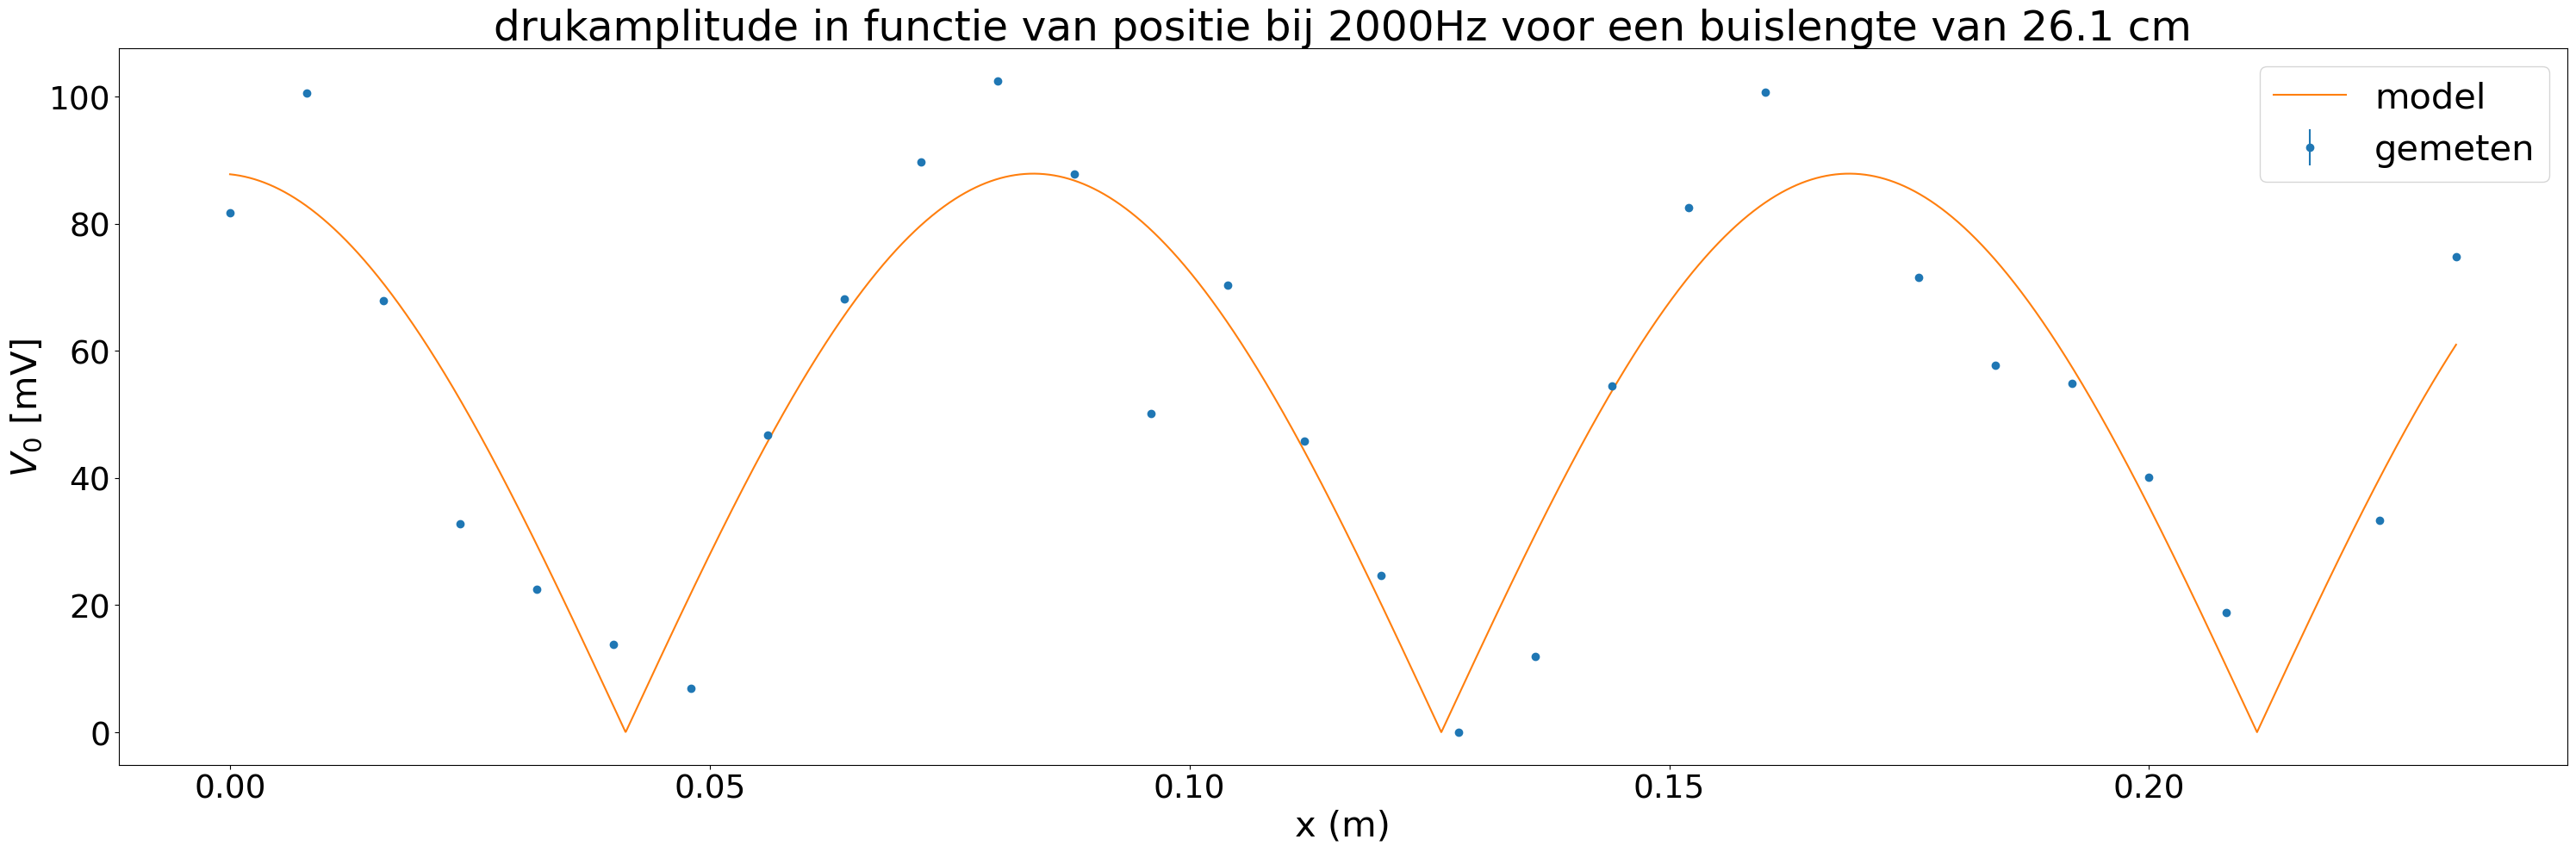

datapunt: v = [354.173896297660, 0.0778793080105628, 'Normaal']
datapunt: r = [1.00000000000000, 0.000523540503103930, 'Normaal']
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
7
tijd: [[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 ...
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]]
nummer: 0
afstand: 0.0
[[0.12383356800290764, 0.12413159200290765],

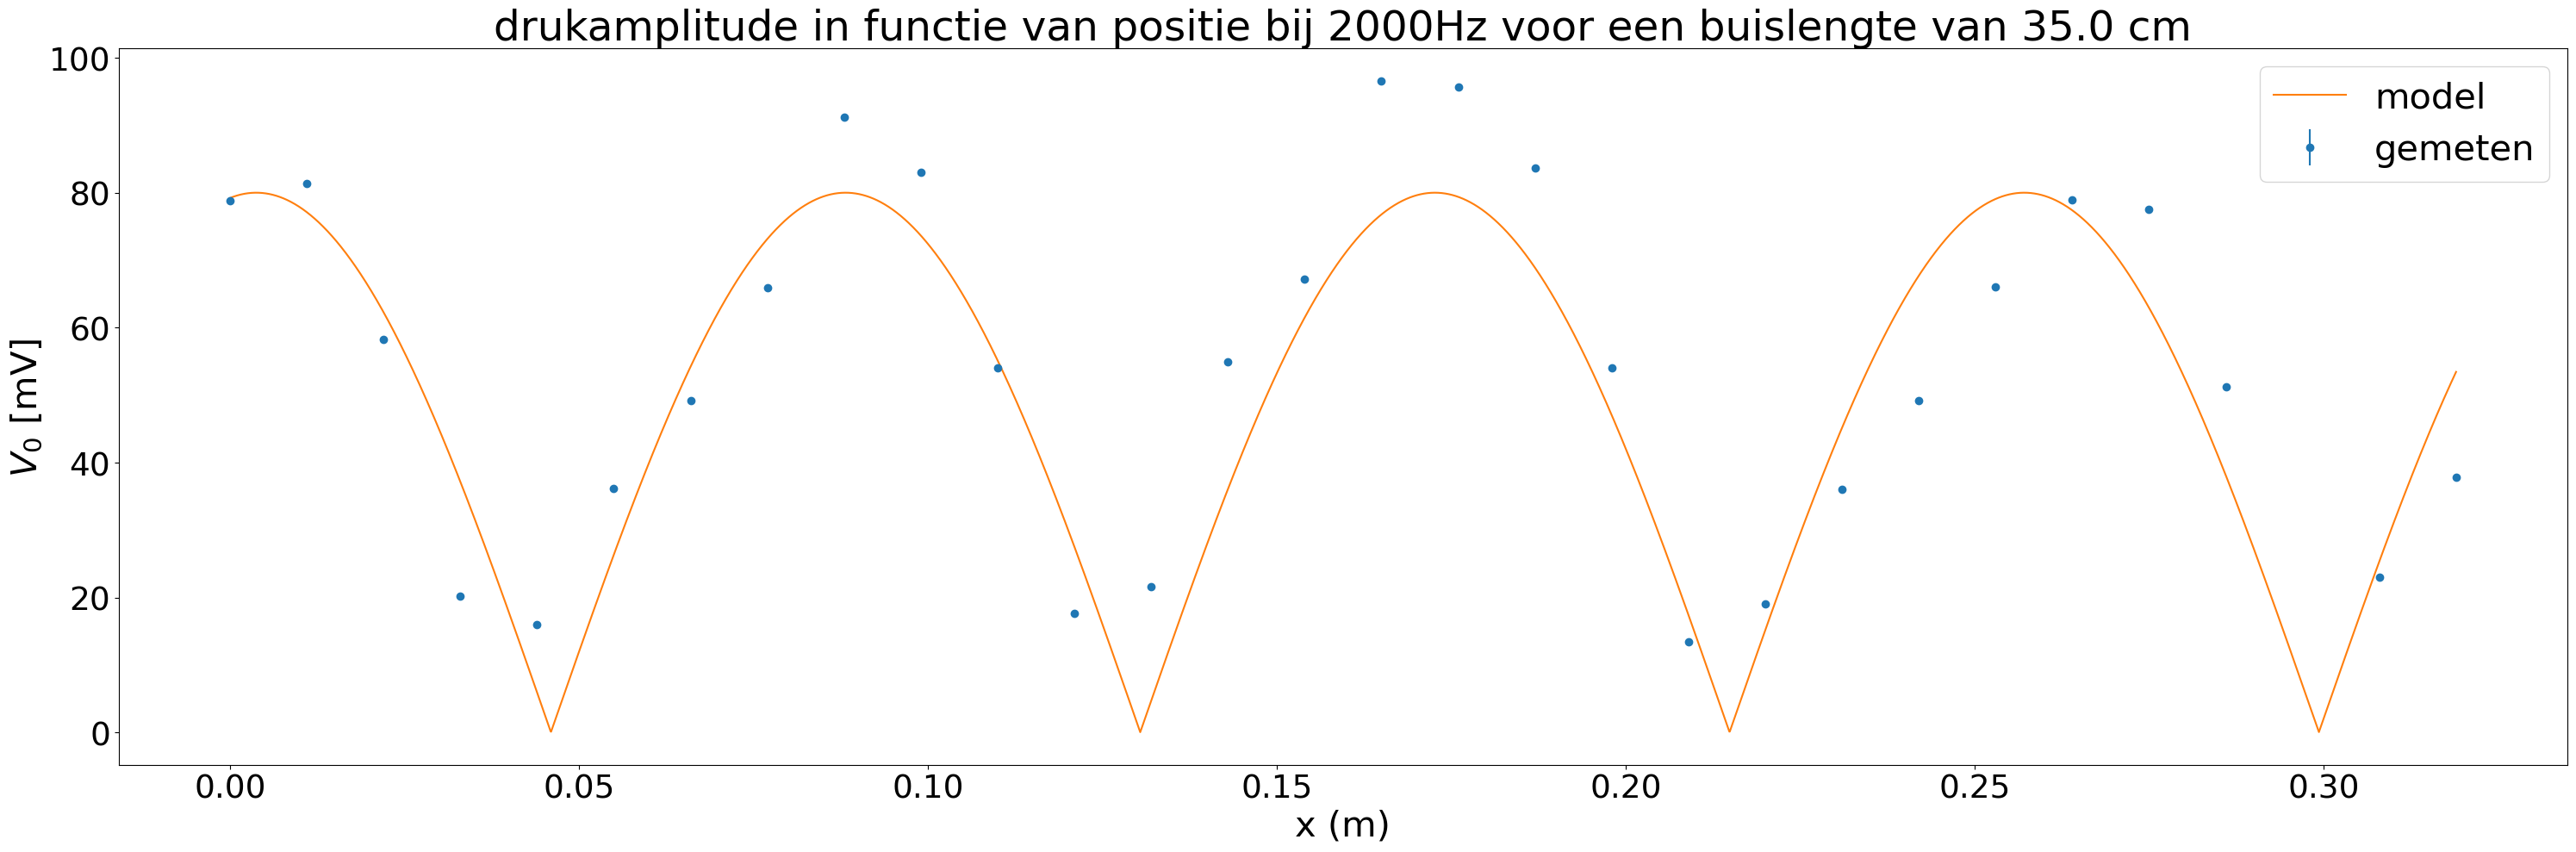

datapunt: v = [333.715689957676, 4.39635531414723, 'Normaal']
datapunt: r = [0.999257373839930, 5.57879357730171e-5, 'Normaal']
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
2
tijd: [[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 ...
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]]
nummer: 0
afstand: 0.0
[[0.12384056627022885, 0.12413859027022886], [80.12518966849424, 80.13413038849424], [1.597784868356579, 1.598082892356579], [12.88868875842795, 12.894947262427952]]
omega heeft als waarde: 0.12399 + 0.00014901 - 0.00014901 met 68% betrouwbaarheidsinterval: [0.12384, 0.12414] 
p_0_x heeft

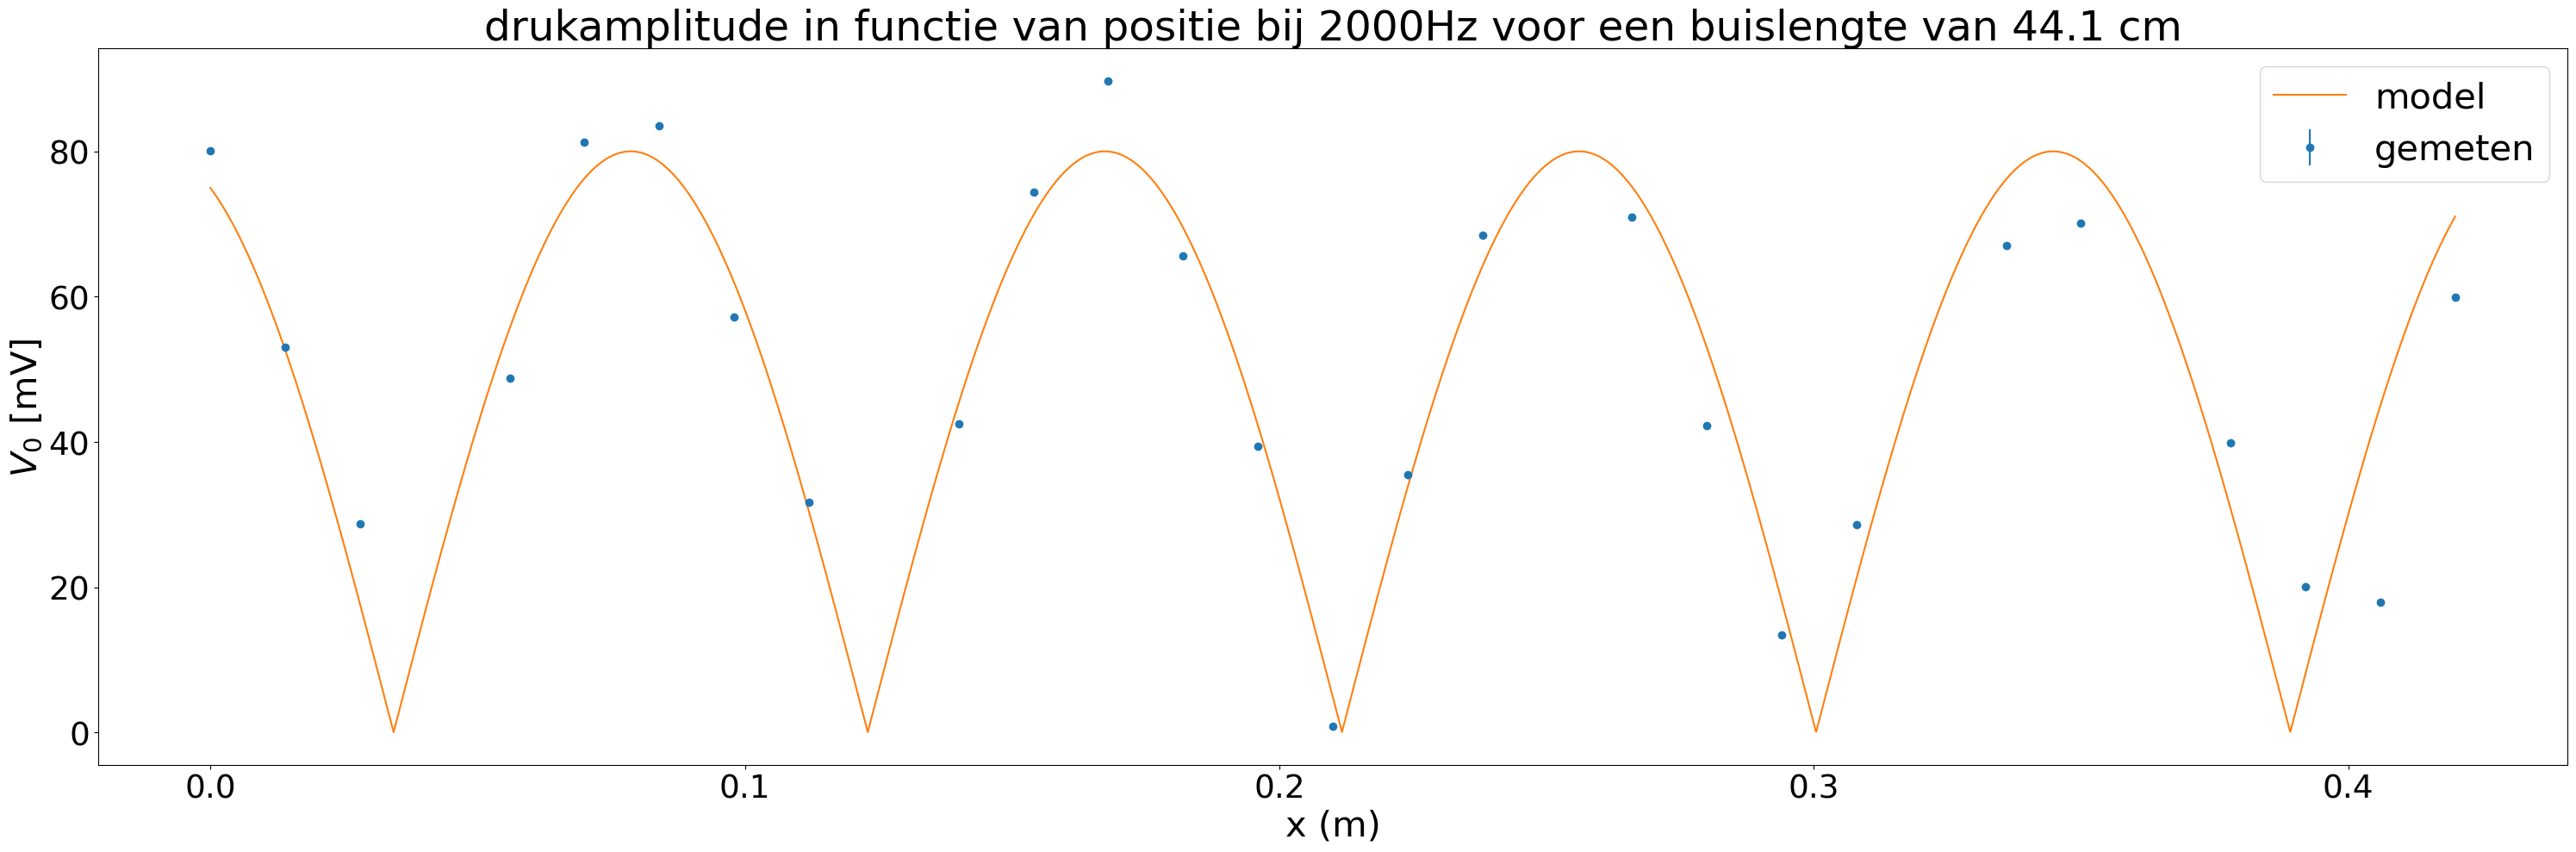

datapunt: v = [351.421043059359, 0.0830865540461167, 'Normaal']
datapunt: r = [0.999358675909824, 3.38462219219073e-5, 'Normaal']
noemer: 55555559.720486455
noemer: 3653333333.333333
________met de 3 experimenten samen:_______
datapunt: v = [354.054836570931, 0.0463360939128956, 'Normaal']


In [ ]:
#de experimenten op 2000Hz

lengtes = ['26.1', '35.0', '44.1']
#lengtes = ['44.1']
stappen = [0.008, 0.011, 0.014] #kijk na zodra je het blad hebt
#hahaha spuug en arbitraire constanten om het aan elkaar te plakken
goksnelheid = [380, 330, 430]
gokranges = [[(35.0, 45), (80, 120), (-1*np.pi,np.pi), (0,20)], [(36.0, 37.2), (80, 100), (-0.1-2*np.pi,2*np.pi), (0,20)], [(35.0, 45), (80, 100), (-0.1-2*np.pi,2*np.pi), (0,20)]]
fuggin = [True, True, True]
fuggin_x = [False, False, False]
Kwaardes = []
omegawaardes = []
for indx in range(len(lengtes)):
    lengte = lengtes[indx]
    mypath = "metingen laweit/2000Hz, "+lengte+"cm"
    titel = "drukamplitude in functie van positie bij 2000Hz voor een buislengte van " + lengte + ' cm'
    V, T, V_fout, afstanden, invals = get_data_from_folder_and_step(mypath, stappen[indx])
    invals_tijd = invals.copy()
    invals_tijd = np.transpose(invals_tijd)
    invals_tijd[3] -= 10
    invals_tijd = np.transpose(invals_tijd)
    kaa, peenul, fie, see, oomeega = fix_data(afstanden, T, V, V_fout, invals_tijd,
                                             gok_snelheid = goksnelheid[indx],fuck_mijn_pc = False, range_x = gokranges[indx], 
                                             detailed_logs=False, print_tijdfit = False, fit_x_vals=True, fuck_CPU = True, return_fit_stats=True, fuck_mijn_pc_x = fuggin_x[indx],
                                               saveto=mypath,titel = titel)
    #amp_x, amp_x_err, initielen = fix_data(afstanden, T, V, V_fout, invals_tijd,
    #                                         gok_snelheid = goksnelheid[indx],fuck_mijn_pc = fuggin[indx], range_x = gokranges[indx], 
    #                                         detailed_logs=True, print_tijdfit = False, fit_x_vals=True, fuck_CPU = True, return_fit_stats=True)
    
    Kwaardes.append(kaa)
    omegawaardes.append(oomeega)
    #amp_x, amp_x_error, invals_x = fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=False, print_tijdfit = False, fit_x_vals=False)
Kvalue = functies.mu_sigma(Kwaardes, k)
Omegavalue = functies.mu_sigma(omegawaardes, omega)
snelheid = functies.data_analyse(snelheid_vergelijking, [Kvalue, Omegavalue], v)
print('________met de 3 experimenten samen:_______')
print(snelheid)

FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
3
tijd: [[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 ...
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]]
invals [[ 6.11353930e-02  1.51000000e+02  1.66066638e+00 -8.04687500e+00]
 [ 6.11353930e-02  1.37500000e+02  1.80365214e+00 -5.11718750e+00]
 [ 6.11982249e-02  1.08000000e+02  1.82636278e+00  2.69531250e+00]
 [ 6.11982249e-02  7.00000000e+01  2.03794244e+00  5.62500000e+00]
 [ 6.11982249e-02  2.63500000e+01  2.24966259e+00  8.55468750e+00]
 [ 6.11353930e-02  3.61000000e+01  1.8984322

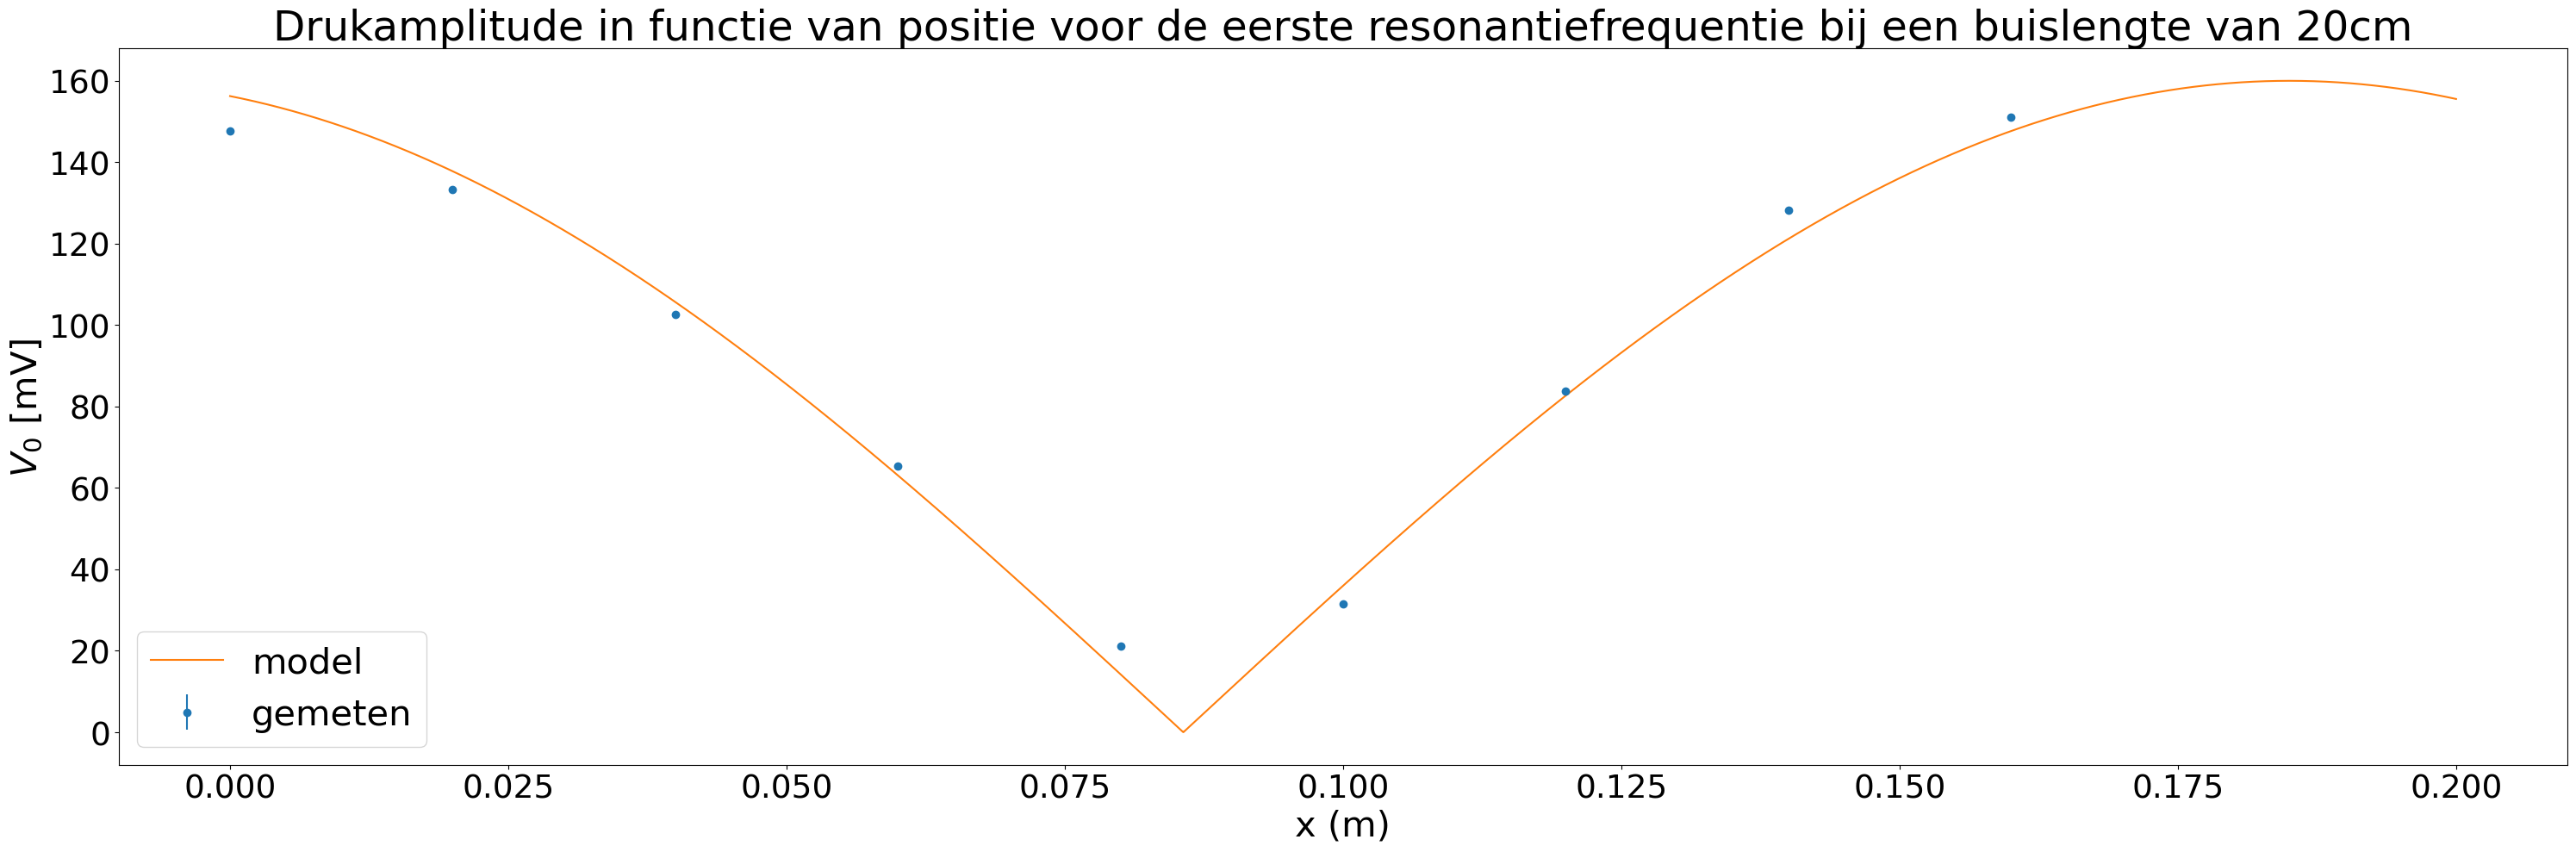

datapunt: v = [387.246414383390, 0.316412248671013, 'Normaal']
datapunt: r = [0.999999999999996, 0.000250007031150970, 'Normaal']
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
1
tijd: [[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 ...
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]]
invals [[ 1.11212380e-01  1.23000000e+02  1.87944840e+00 -2.18750000e+00]
 [ 1.11212380e-01  6.35000000e+01  1.82095549e+00  6.60156250e+00]
 [ 1.10584061e-01  1.75500000e+01  2.24848463e+00  7.57812500e+00]
 [ 1.11212380e-01  9.45000000e+01  1.76224559e+00 -3.16406250e+00]
 [ 1.11212380e-01  1.41500000e+02  1.85704884e+00 -1.09765625e

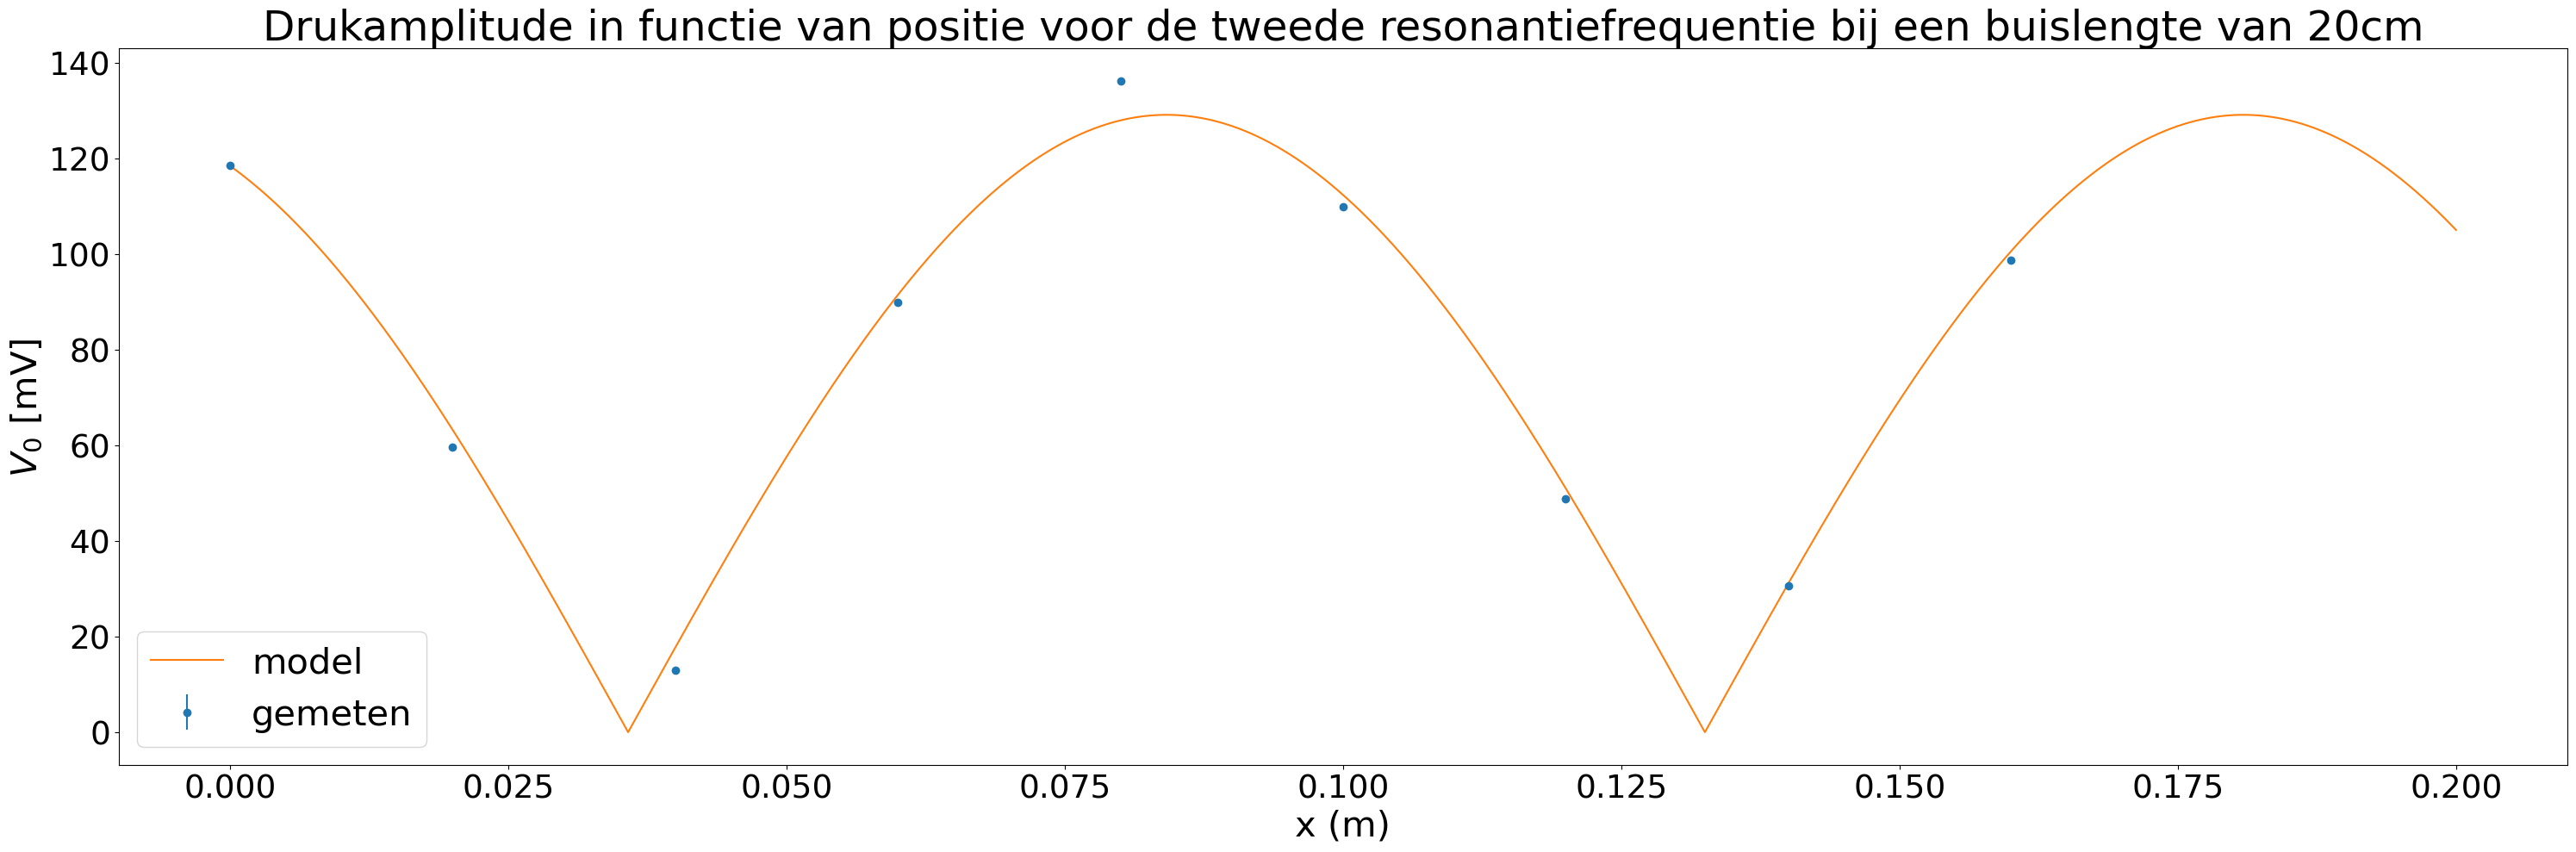

datapunt: v = [342.750271287413, 0.154049197132165, 'Normaal']
datapunt: r = [1.00000000000000, 8.83392176287053e-5, 'Normaal']
[datapunt: v = [387.246414383390, 0.316412248671013, 'Normaal'], datapunt: v = [342.750271287413, 0.154049197132165, 'Normaal']]
noemer: 52.1270413580405
_______gemiddelde snelheid_______
datapunt: v = [351.276416362155, 0.138505960102700, 'Normaal']


In [22]:
#de experimenten op 20cm

stappen = [2e-2, 2e-2] #kijk na zodra je het blad hebt
#hahaha spuug en arbitraire constanten om het aan elkaar te plakken
#bij de eerste: k ong 17.8
goksnelheid = [380, 329]
gokranges = [[(0,0.22e2), (100, 160), (0,np.pi), (0,10)], [(0, 1e2), (100, 140), (-0.1-2*np.pi,2*np.pi), (0,20)]]
fuggin = [False, True]
fuggin_x = [False, False]
CPUfuggin = [True, True]
loglijst = [False, False]
invals_x_lijst = [[0.194e2, 146.92, np.pi/2, 0.5], [50*1.8/2, 120, 1.3, 0]]
vwaardes = []
opslaglijst = ["metingen laweit/20cm, resfreq 1img.png", "metingen laweit/20cm, resfreq 2img.png"]
titellijst = ["Drukamplitude in functie van positie voor de eerste resonantiefrequentie bij een buislengte van 20cm", 
              "Drukamplitude in functie van positie voor de tweede resonantiefrequentie bij een buislengte van 20cm"]

maalwaardes = [1/1000,1]
for indx in range(1,3):
    mypath = "metingen laweit/20cm, resfreq" + str(indx)
    V, T, V_fout, afstanden, invals = get_data_from_folder_and_step(mypath, stappen[indx-1])
    invals_tijd = invals.copy()
    invals_tijd = np.transpose(invals_tijd)
    invals_tijd[0] *= maalwaardes[indx-1]
    invals_tijd[3] -= 10
    invals_tijd = np.transpose(invals_tijd)
    print('invals',invals_tijd)
    kaa, peenul, fie, see, oomeega = fix_data(afstanden, T, V, V_fout, invals_tijd,
                                             gok_snelheid = goksnelheid[indx-1],fuck_mijn_pc = fuggin[indx-1], range_x = gokranges[indx-1], invals_x = invals_x_lijst[indx-1],
                                             detailed_logs=loglijst[indx-1], print_tijdfit = False, fit_x_vals=True, fuck_CPU = CPUfuggin[indx-1], fuck_mijn_pc_x= fuggin_x[indx-1],
                                             saveto = opslaglijst[indx-1], titel=titellijst[indx-1], x_plot_max=20e-2)
    vwaardes.append(functies.data_analyse(snelheid_vergelijking,[kaa, oomeega], v))
    #amp_x, amp_x_error, invals_x = fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=False, print_tijdfit = False, fit_x_vals=False)
print(vwaardes)
snelheid = functies.mu_sigma(vwaardes,v)
print('_______gemiddelde snelheid_______')
print(snelheid)
#20cm

0
tijd: [[0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 ...
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]
 [0.0000e+00 4.0000e-01 8.0000e-01 ... 1.9988e+03 1.9992e+03 1.9996e+03]]
invals [[ 4.27884919e-02  6.60000000e+01  2.04908454e+00 -1.19531250e+01]
 [ 4.28513238e-02  7.20000000e+01  2.23618750e+00 -1.39062500e+01]
 [ 4.28513238e-02  6.90000000e+01  2.22657646e+00 -1.19531250e+01]
 [ 4.28513238e-02  6.40000000e+01  2.08689517e+00 -1.09765625e+01]
 [ 4.27884919e-02  5.45000000e+01  2.17270819e+00 -1.19531250e+01]
 [ 4.27884919e-02  4.19500000e+01  1.94398905e+00 -1.00000000e+01]
 [ 4.27884919e-02  2.53500000e+01  2.37537183e+00 -1.00000000e+01]
 [ 4.27884919e-02  3.41500000e+01  2.05190101e+00 -1.09765625e+01]
 [ 4.

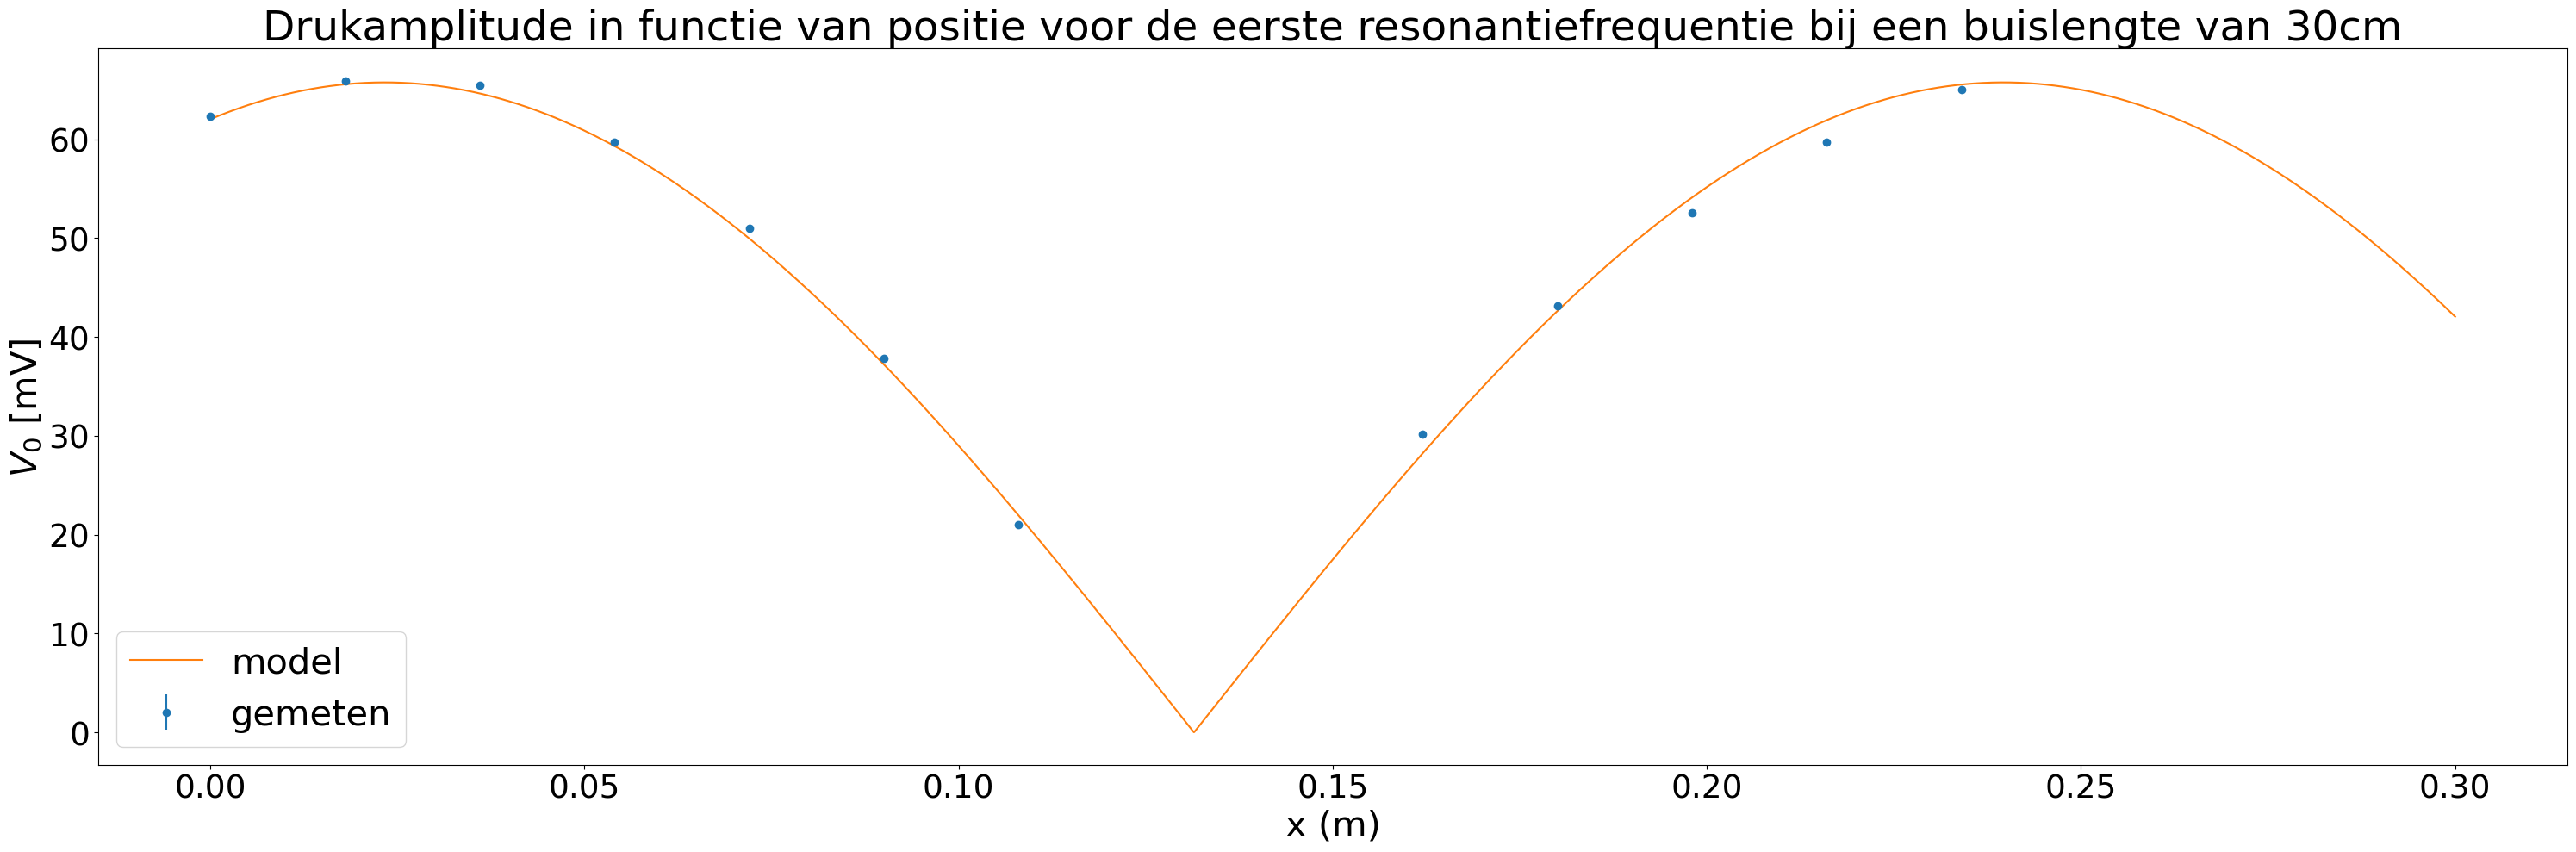

datapunt: v = [295.066596535911, 0.298435071632451, 'Normaal']
datapunt: r = [1.00000000000000, 0.000334666347362230, 'Normaal']
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YOU DE DATA IS COOKED
FUCK YO

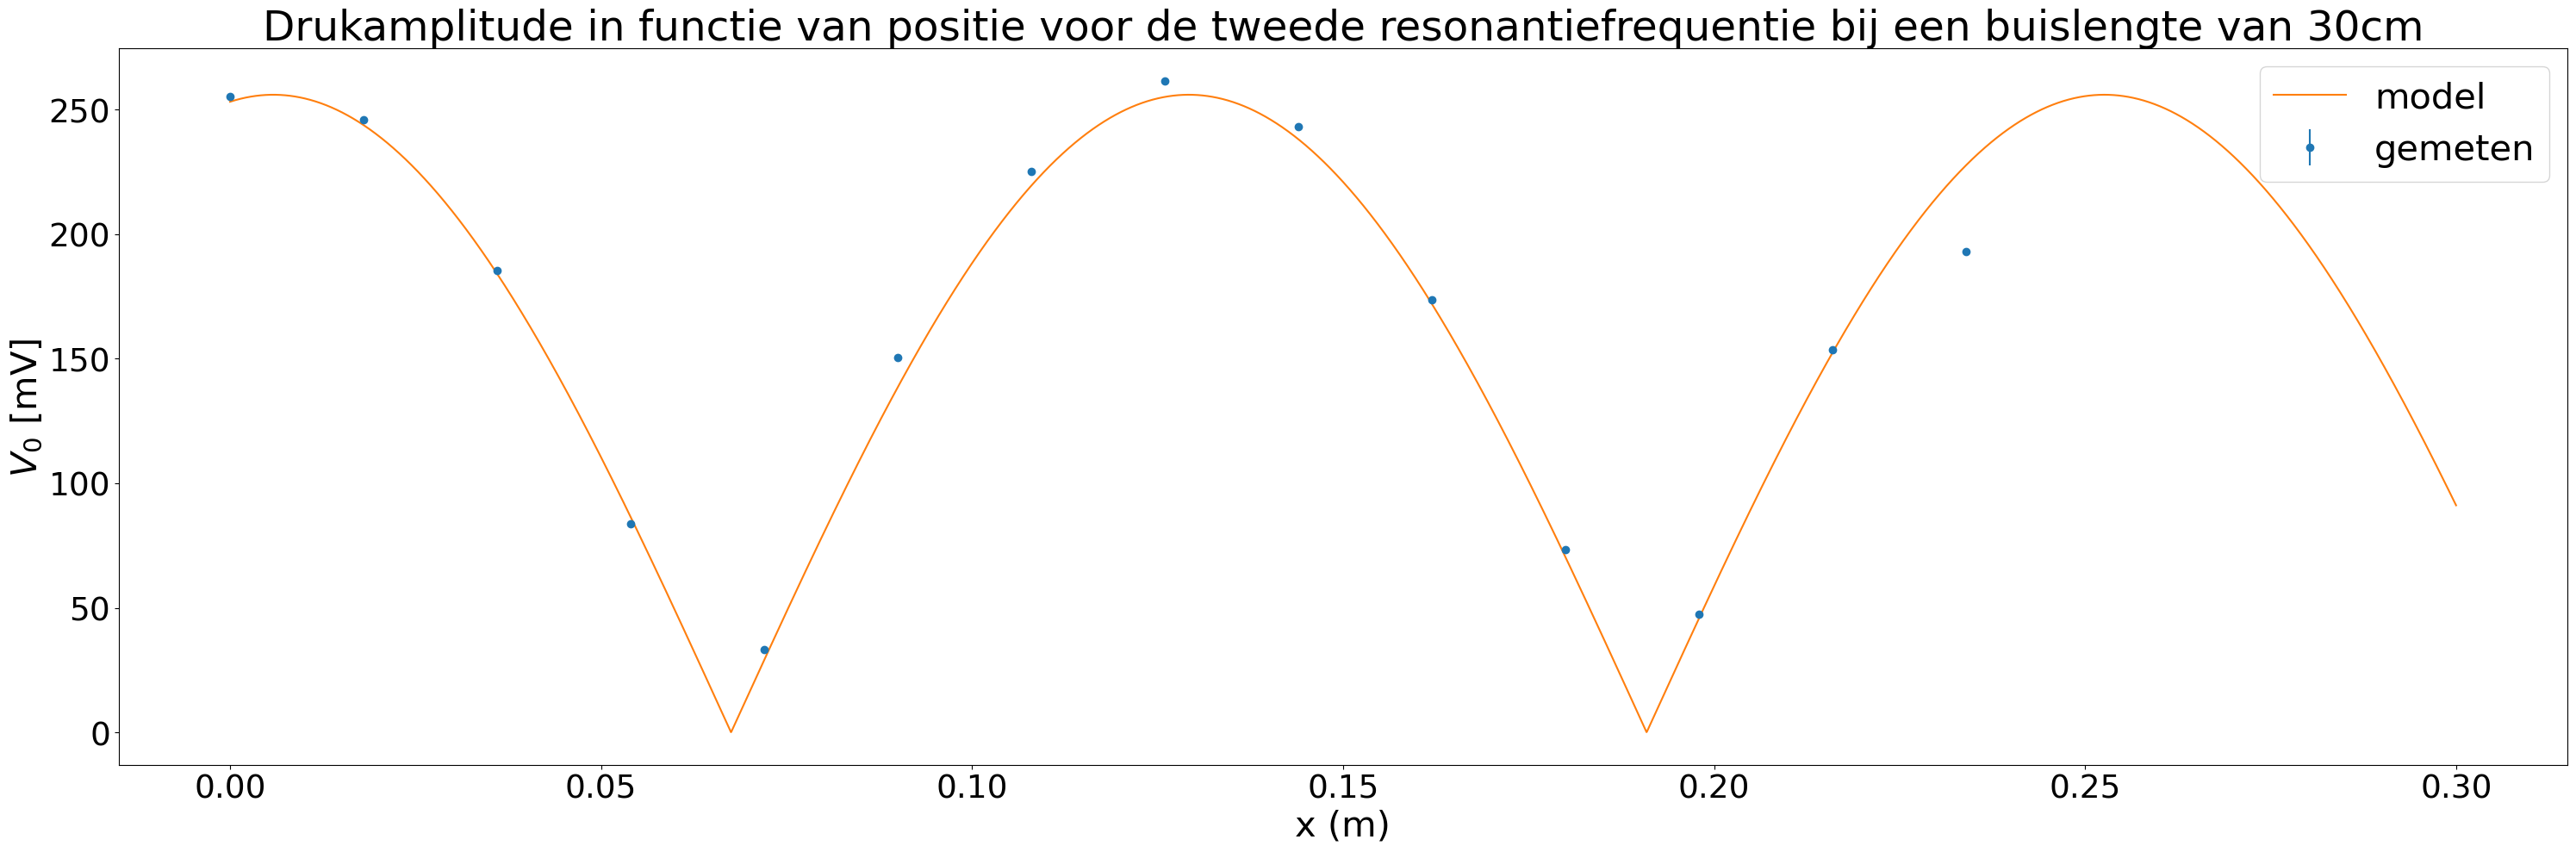

datapunt: v = [305.600984830578, 0.157461806489809, 'Normaal']
datapunt: r = [1.00015023876164, 1.21743957246354e-6, 'Normaal']
noemer: 51.5599248987504
_______gemiddelde snelheid_______
datapunt: v = [303.306964157355, 0.139265602364600, 'Normaal']


In [ ]:
#de experimenten op 30cm

stappen = [2e-2, 2e-2] #kijk na zodra je het blad hebt
#hahaha spuug en arbitraire constanten om het aan elkaar te plakken
#bij de eerste: k ong 17.8
goksnelheid = [380, 329]
gokranges = [[(10,18), (50, 100), (0,np.pi), (0,10)],None,[(0, 40), (10, 140), (-0.1-2*np.pi,2*np.pi), (0,20)]]
fuggin = [False, True]
fuggin_x = [False, False]
CPUfuggin = [True, True]
loglijst = [False, False]
tijdlijst = [False, False]
invals_x_lijst = [[15, 75, np.pi/2, 0.5],[19, 100, 1.3, 0]]

opslaglijst = ["metingen laweit/30cm, resfreq 1img.png", "metingen laweit/30cm, resfreq 2img.png"]
titellijst = ["Drukamplitude in functie van positie voor de eerste resonantiefrequentie bij een buislengte van 30cm", 
              "Drukamplitude in functie van positie voor de tweede resonantiefrequentie bij een buislengte van 30cm"]
vwaardes = []
maalwaardes = [1/1000,1]
for indx in range(1,3):
    mypath = "metingen laweit/30cm, resfreq" + str(indx)
    V, T, V_fout, afstanden, invals = get_data_from_folder_and_step(mypath, stappen[indx-1])
    invals_tijd = invals.copy()
    invals_tijd = np.transpose(invals_tijd)
    invals_tijd[0] *= maalwaardes[indx-1]
    invals_tijd[3] -= 10
    invals_tijd = np.transpose(invals_tijd)
    print('invals',invals_tijd)
    kaa, peenul, fie, see, oomeega = fix_data(afstanden, T, V, V_fout, invals_tijd,
                                             gok_snelheid = goksnelheid[indx-1],fuck_mijn_pc = fuggin[indx-1], range_x = gokranges[indx-1], invals_x = invals_x_lijst[indx-1],
                                             detailed_logs=loglijst[indx-1], print_tijdfit = tijdlijst[indx-1], fit_x_vals=True, fuck_CPU = CPUfuggin[indx-1], fuck_mijn_pc_x= fuggin_x[indx-1],
                                             saveto = opslaglijst[indx-1], titel=titellijst[indx-1], gun_punten = loglijst[indx-1], x_plot_max=30e-2)
    vwaardes.append(functies.data_analyse(snelheid_vergelijking,[kaa, oomeega], v))
    #amp_x, amp_x_error, invals_x = fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=False, print_tijdfit = False, fit_x_vals=False)
    
snelheid = functies.mu_sigma(vwaardes,v)
print('_______gemiddelde snelheid_______')
print(snelheid)
#30cm